In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook I will fine-tune BERT with PyTorch framework to perform a classification task by using Natural Language Processing with Disaster Tweets dataset. 
In this notebook, I will:

    Load the Disaster Tweets dataset
    Pre-processing of tweets
    Load a BERT model from TensorFlow Hub
    Build a BertForSequenceClassification model
    Train the model and fine-tuning BERT
    Perform a tweet classification for submission


In [2]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.2MB/s 
     |████████████████████████████████| 901kB 19.0MB/s 
     |████████████████████████████████| 3.3MB 30.1MB/s 


In [3]:
#import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch.nn.functional as F


import pandas as pd
import numpy as np
import time
import datetime
import random, re
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Check device 
# Get the GPU device name if available.
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))

    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: Tesla V100-SXM2-16GB


In [68]:
# Read the data
train = pd.read_csv(r'/content/drive/MyDrive/DM/data/nlp-getting-started/train.csv')
test = pd.read_csv(r'/content/drive/MyDrive/DM/data/nlp-getting-started/test.csv')
pd.set_option('display.max_colwidth', 150)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of test sentences: {:,}\n'.format(test.shape[0]))

Number of training sentences: 7,613

Number of test sentences: 3,263



In [69]:
def clean_text(text):
    text = text.lower() #lowercase
    
    text = re.sub(r'[!]+','!',text)
    text = re.sub(r'[?]+','?',text)
    text = re.sub(r'[.]+','.',text)
    text = re.sub(r"'","",text)
    #text = re.sub('\s+', '', text)#.strip() # Remove and double spaces
    text = re.sub(r'&amp;?',r'and', text) # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text) # Remove URLs
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+','',text) #remove some puncts (except . ! # ?)
    
    return text

train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake may allah forgive us all,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,13000 people receive #wildfires evacuation orders in california,1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school,1


In [71]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size = 0.2, random_state = 42, stratify = train['target'])

In [72]:
# importing libraries
import tensorflow as tf
from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [73]:
train['text'][0]

'our deeds are the reason of this #earthquake may allah forgive us all'

In [74]:
VOC_SIZE = 30000
onehot_repr_train = [one_hot(words, VOC_SIZE) for words in train['text']]
onehot_repr_val = [one_hot(words, VOC_SIZE) for words in val['text']]
print(onehot_repr_train[3000])
SENT_LENGTH = 15
embedded_docs_train = pad_sequences(onehot_repr_train, padding="post", maxlen=SENT_LENGTH)
embedded_docs_val = pad_sequences(onehot_repr_val, padding="post", maxlen=SENT_LENGTH)

[22359, 15904, 2856, 14995, 8493, 15503, 2999, 13138, 2993, 5961]


In [78]:
def create_model():
  VECT_FEATURES = 32
  model = Sequential()
  model.add(Embedding(VOC_SIZE,
                      VECT_FEATURES,
                      input_length=SENT_LENGTH))
  model.add(LSTM(100, return_sequences = True))
  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))
  return model

In [79]:
model = create_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"]) # compiling
model.summary() #summary

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 32)            960000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 100)           53200     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)               

In [92]:
history = model.fit(embedded_docs_train, train['target'], validation_data=
                    (embedded_docs_val, val['target']),epochs=3, batch_size=32)

Epoch 1/3
153/153 [==============================] - 2s 14ms/step - loss: 0.0236 - accuracy: 0.9875 - val_loss: 3.2400 - val_accuracy: 0.7488
Epoch 2/3
153/153 [==============================] - 2s 14ms/step - loss: 0.0219 - accuracy: 0.9881 - val_loss: 3.2718 - val_accuracy: 0.7570
Epoch 3/3
153/153 [==============================] - 2s 14ms/step - loss: 0.0226 - accuracy: 0.9867 - val_loss: 3.5383 - val_accuracy: 0.7586


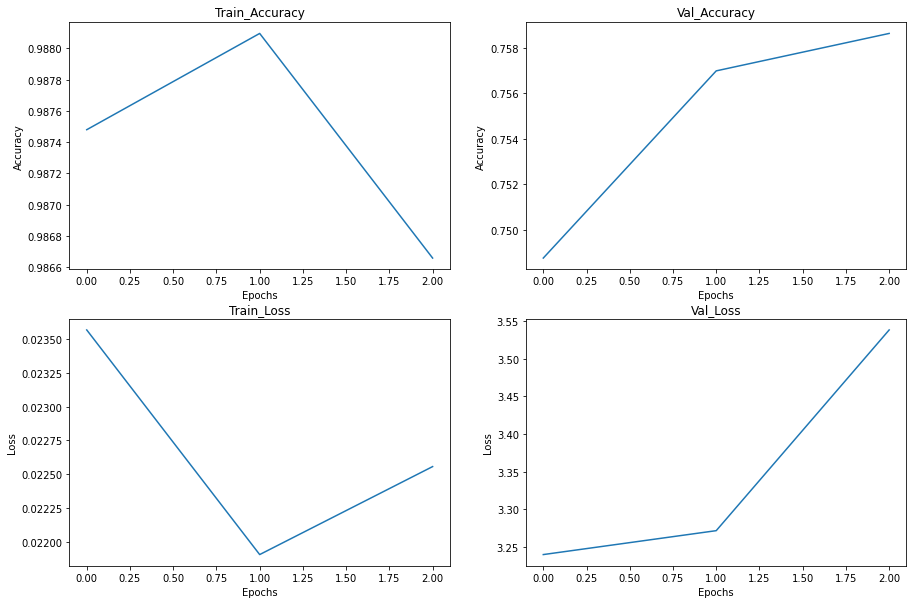

In [93]:
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(2,2,figsize=(15,10))
ax1[0].plot(history.history["accuracy"])
ax1[0].set_title("Train_Accuracy")
ax1[0].set_xlabel("Epochs")
ax1[0].set_ylabel("Accuracy")

ax1[1].plot(history.history["val_accuracy"])
ax1[1].set_title("Val_Accuracy")
ax1[1].set_xlabel("Epochs")
ax1[1].set_ylabel("Accuracy")

ax2[0].plot(history.history["loss"])
ax2[0].set_title("Train_Loss")
ax2[0].set_xlabel("Epochs")
ax2[0].set_ylabel("Loss")

ax2[1].plot(history.history["val_loss"])
ax2[1].set_title("Val_Loss")
ax2[1].set_xlabel("Epochs")
ax2[1].set_ylabel("Loss")
plt.show()

In [83]:
import numpy as np

data_test = pd.read_csv(r'/content/drive/My Drive/DM/data/processed_test.txt',sep = ',',
                         encoding = 'utf-8', header=None)

data_answer = pd.read_csv(r'/content/drive/My Drive/DM/data/answer.csv',sep = ',',
                         encoding = 'utf-8', header=None, index_col=0)

VOC_SIZE = 30000

print(data_test[2])
test = np.array(data_test[2],dtype = str)
onehot_repr = [one_hot(words, VOC_SIZE) for words in test]

SENT_LENGTH = 15
embedded_docs = pad_sequences(onehot_repr, padding="post", maxlen=SENT_LENGTH)
embedded_docs

pred = model.predict(embedded_docs)
data_answer = np.array(data_answer[1][1:],dtype=int)

0                                                                                happen terribl car crash
1                                                           heard earthquak differ citi stay safe everyon
2                                                      forest fire spot pond gees flee across street save
3                                                                          apocalyps light spokan wildfir
4                                                                      typhoon soudelor kill china taiwan
                                                      ...                                                
3258                                                        earthquak safeti los angel safeti fasten xrwn
3259    storm wors last hurrican cityand other hardest hit yard look like bomb around still without power
3260                                                                            green line derail chicago
3261                                          

In [84]:
correct=0
sums=0
for i in range(len(pred)):
  if (pred[i] < 0.5):
    pred[i] = 0
  else:
    pred[i] = 1
  if (pred[i] == data_answer[i]):
    correct+=1
  sums+=1
    
print(correct/sums)

0.6840330983757279
